In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year', 'Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_d.shape

(60, 1)

In [5]:
sales_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_d['Sales'].sum()

7173488

Text(0.5, 1.0, 'Product D')

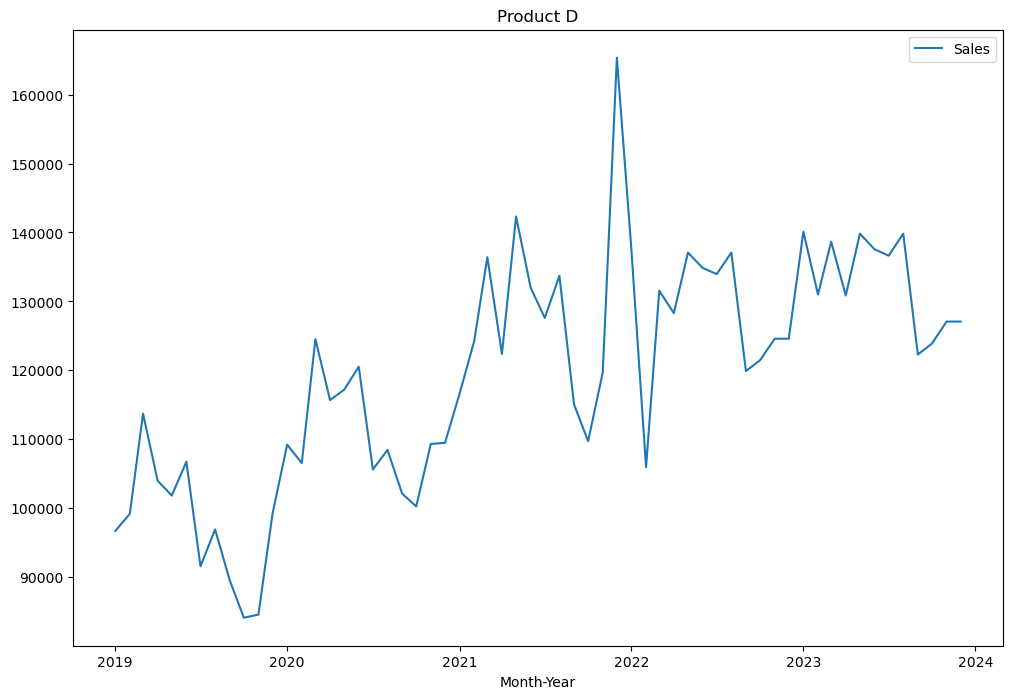

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_d)
plt.title('Product D')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_d)

ADF Statistics: -2.3249460487083105
p- value: 0.16404854202961083
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_d_diff= sales_d.diff().dropna()

Text(0.5, 1.0, 'Product D- First Difference')

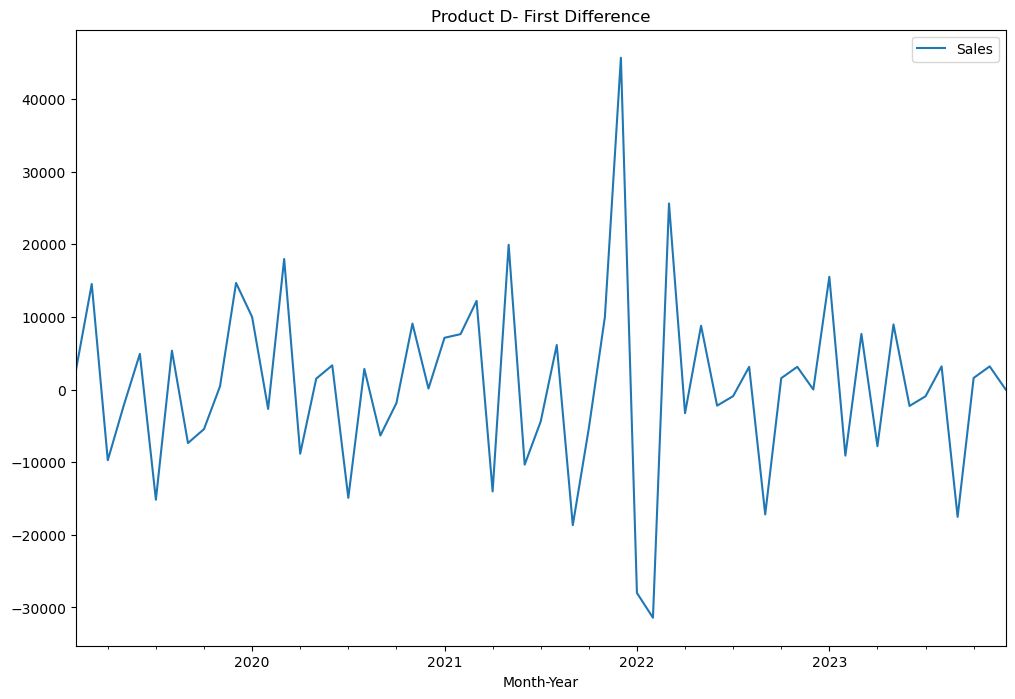

In [11]:
sales_d_diff.plot(figsize=(12,8))
plt.title('Product D- First Difference')

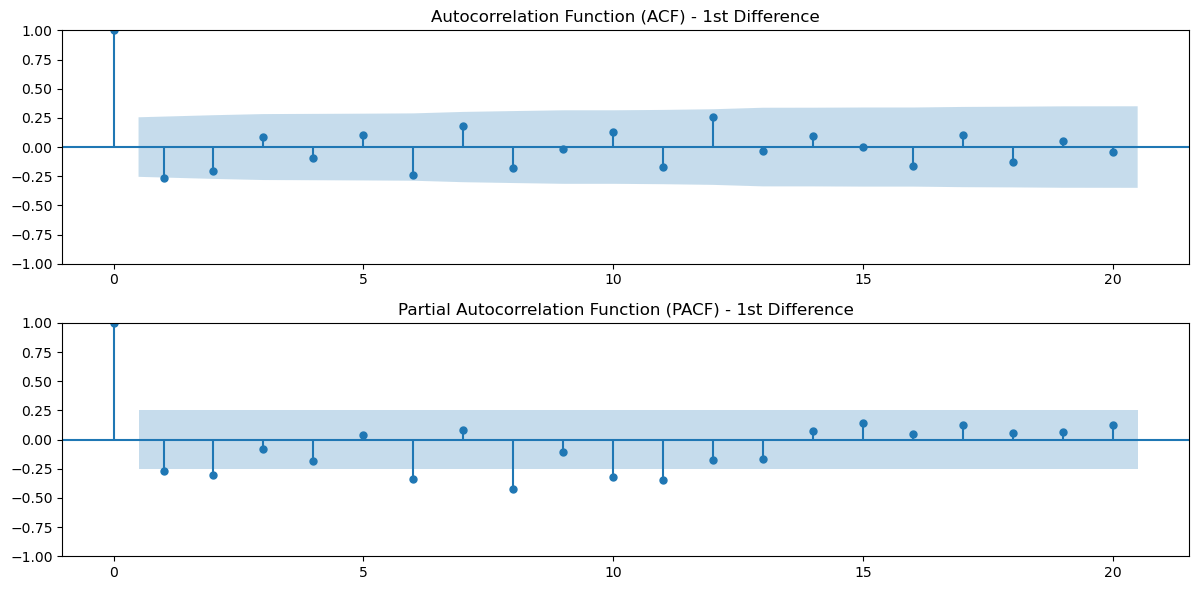

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_d_diff)

ADF Statistics: -4.6011480666771325
p- value: 0.00012854172822943823
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_d[:48]
test=sales_d[48:]

In [15]:
len(train)

48

In [16]:
# combination p=(1,2,3,4,5) d=1 q=(0,1) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(1,1,0), (1, 1, 1), (2,1,0), (2, 1, 1),(3,1,0), (3, 1, 1),(4,1,0), (4, 1, 1), (5,1,0), (5, 1, 1)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_d)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic          mae           mse          rmse
0   0  0  1027.268045  1029.118192  8815.500000  1.096857e+08  10473.091982
1   0  1  1028.157171  1031.857466  8842.170460  1.103528e+08  10504.893025
2   1  0  1028.271711  1031.972006  8815.500000  1.096857e+08  10473.091982
3   1  1  1029.234408  1034.784851  8283.579237  9.710283e+07   9854.077045
4   2  0  1030.413164  1035.963607  8922.803084  1.123958e+08  10601.686208
5   2  1  1031.402679  1038.803270  8285.149698  9.713724e+07   9855.822598
6   3  0  1032.210915  1039.611505  9006.997698  1.145028e+08  10700.598274
9   4  1  1032.591389  1043.692275  8726.351573  1.062860e+08  10309.509852
7   3  1  1033.381623  1042.632361  8213.958680  9.555702e+07   9775.327139
11  5  1  1033.748751  1046.699784  9384.375432  1.224599e+08  11066.158059
8   4  0  1033.906220  1043.156958  8661.251323  1.058186e+08  10286.817111
10  5  0  1035.540627  1046.641512  8964.142945  1.129318e+08  10626.937401


In [20]:
m_arima= ARIMA (train, order=(0,1,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -512.634
Date:                Thu, 09 May 2024   AIC                           1027.268
Time:                        16:28:16   BIC                           1029.118
Sample:                    01-01-2019   HQIC                          1027.964
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.706e+08   2.43e+07      7.021      0.000    1.23e+08    2.18e+08
Ljung-Box (L1) (Q):                   2.95   Jarque-Bera (JB):                 8.91
Prob(Q):                              0.09   Pr

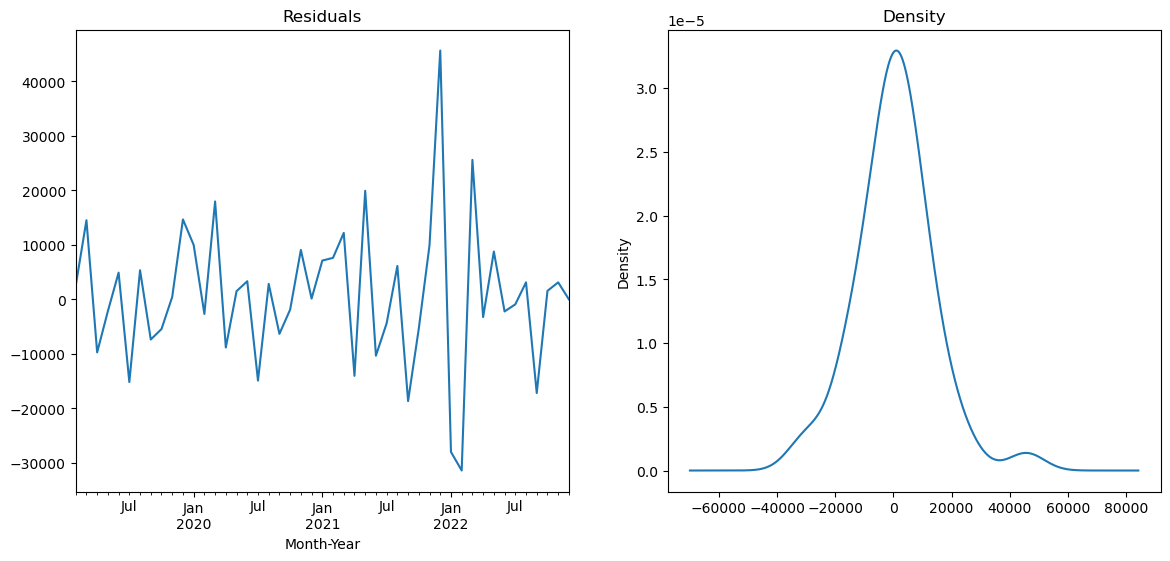

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

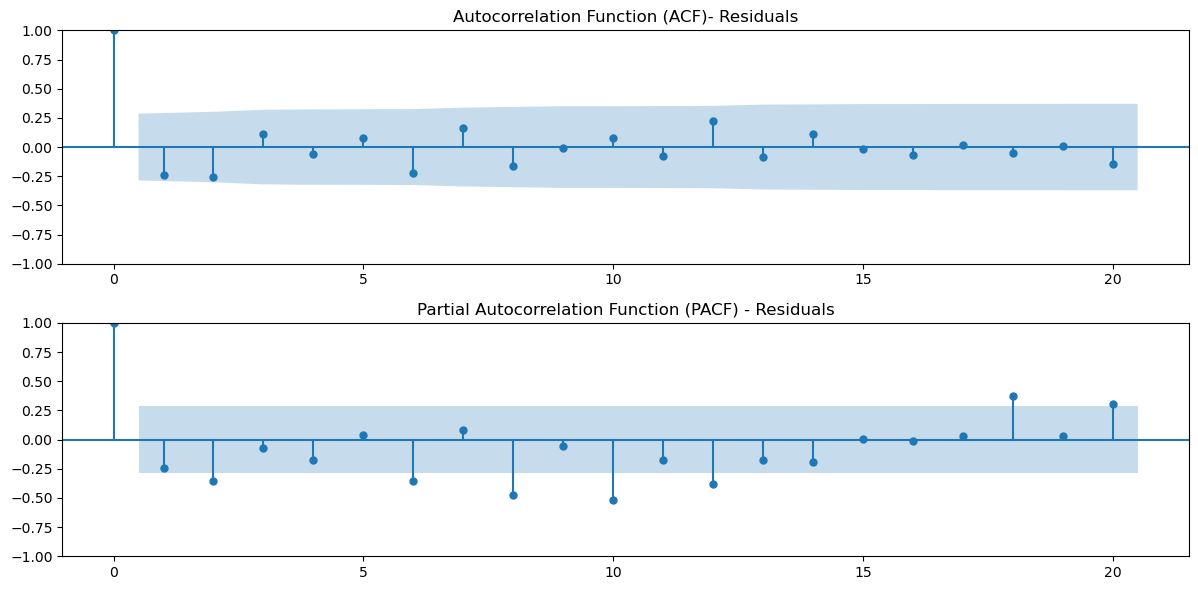

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

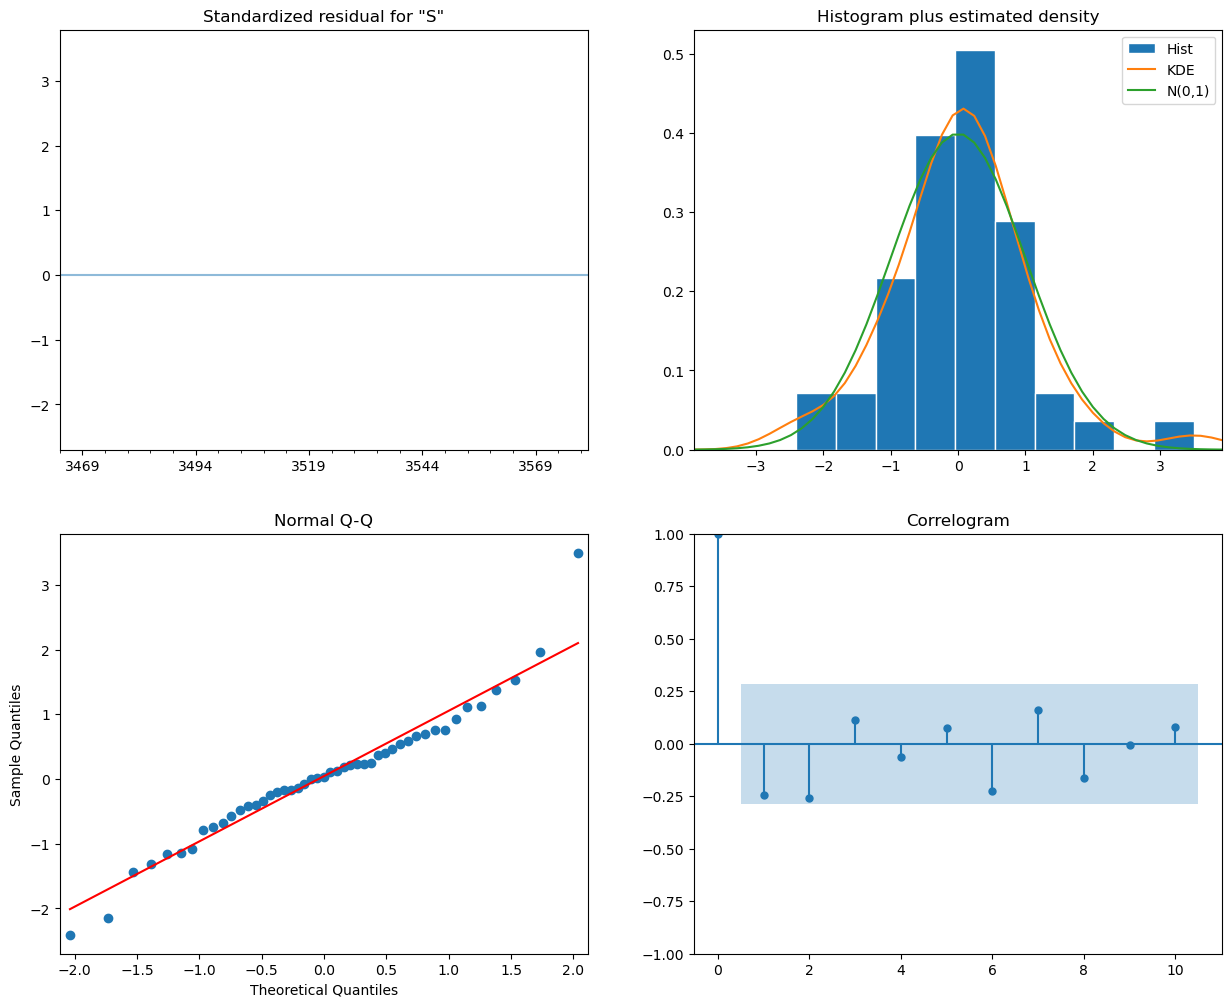

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_d.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_d)-1), dynamic = True)
sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)

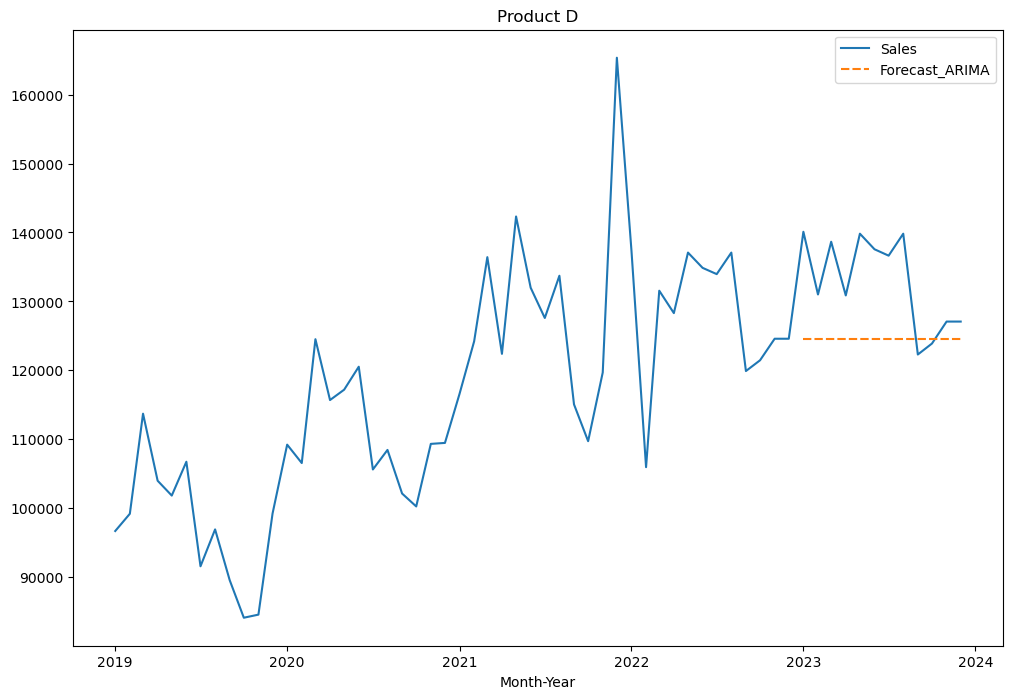

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_ARIMA']])
plt.title('Product D')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 8815.5
MAPE - ARIMA: 0.06445481425611801
MSE - ARIMA: 109685655.66666667
RMSE - ARIMA: 10473.091982154396


In [28]:
sales_d[['Sales','Forecast_ARIMA']].tail(12)

,Sales,Forecast_ARIMA
Month-Year,,
2023-01-01,140104,124583.0
2023-02-01,131006,124583.0
2023-03-01,138656,124583.0
2023-04-01,130866,124583.0
2023-05-01,139824,124583.0
2023-06-01,137565,124583.0
2023-07-01,136637,124583.0
2023-08-01,139824,124583.0
2023-09-01,122293,124583.0


# SARIMA

In [29]:
import statsmodels.api as sm

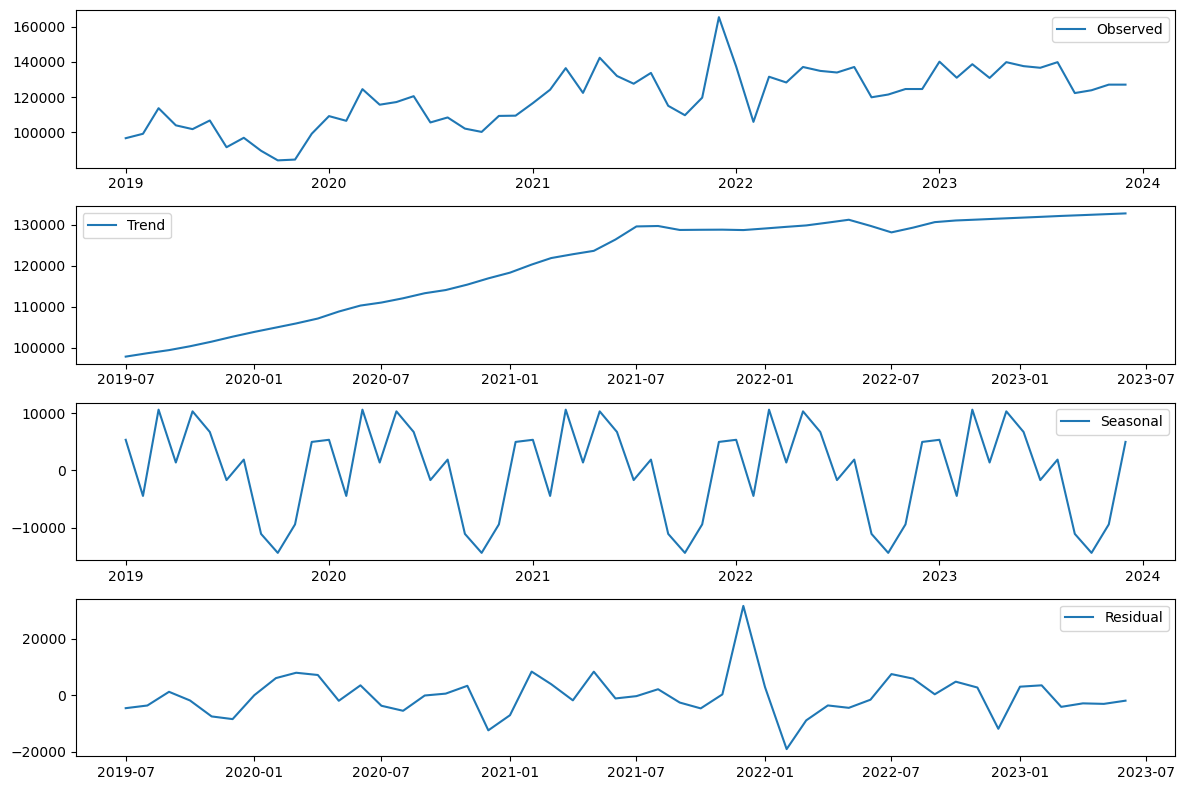

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_d['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

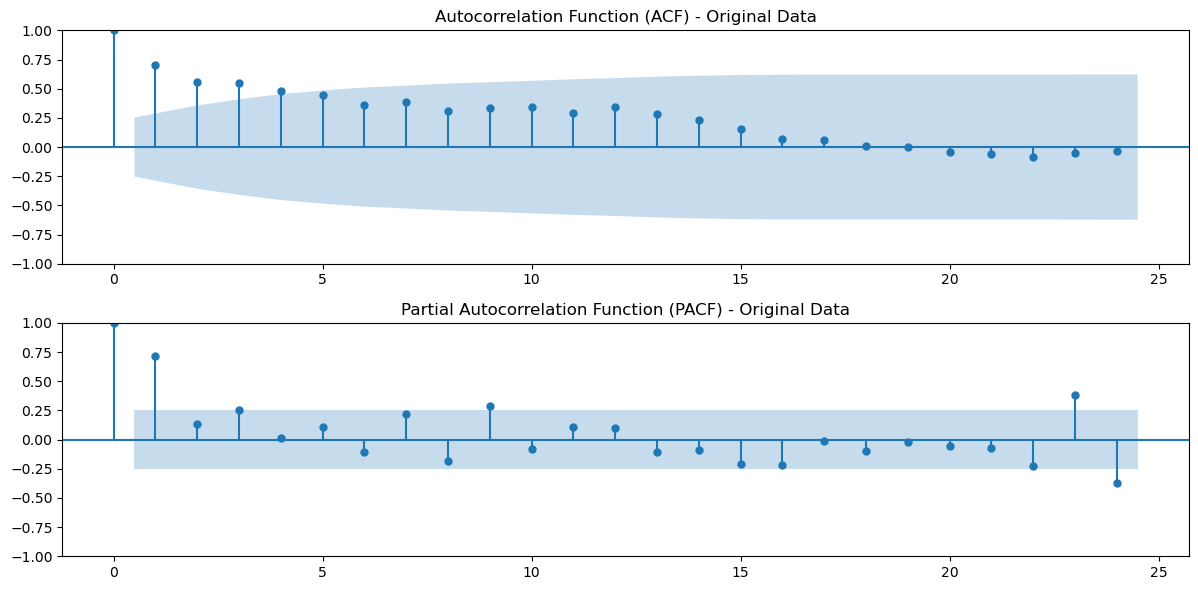

In [33]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [35]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 1, 0), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [36]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic           mae           mse
12  3  0  1023.585607  1030.986197  15727.507928  2.895485e+08
3   0  3  1024.305487  1031.706078  11153.472908  1.536137e+08
2   0  2  1024.527629  1030.078072  16062.383947  2.920527e+08
6   1  2  1024.655085  1032.055675   6063.697865  4.540753e+07
7   1  3  1026.254886  1035.505624  18051.418524  3.666153e+08
10  2  2  1026.617121  1035.867859   6801.826766  5.819771e+07
4   1  0  1026.732718  1030.433014  14912.895932  2.508577e+08
16  4  0  1026.787810  1036.038548  14613.776547  2.519242e+08
0   0  0  1027.268045  1029.118192   8815.500000  1.096857e+08
11  2  3  1028.215670  1039.316556  13387.255970  2.165243e+08
14  3  2  1028.329171  1039.430057  14730.390678  2.556552e+08
17  4  1  1028.549052  1039.649938  14655.439921  2.532884e+08
8   2  0  1028.561639  1034.112082  10799.890309  1.460212e+08
15  3  3  1030.127392  1043.078425  14781.107058  2.572995e+08
18  4  2  1030.329175  1043.280208  14703.557622  2.548

In [37]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 1, 0),seasonal_order=(3,0,0,12))
sarima_model=sarima.fit()

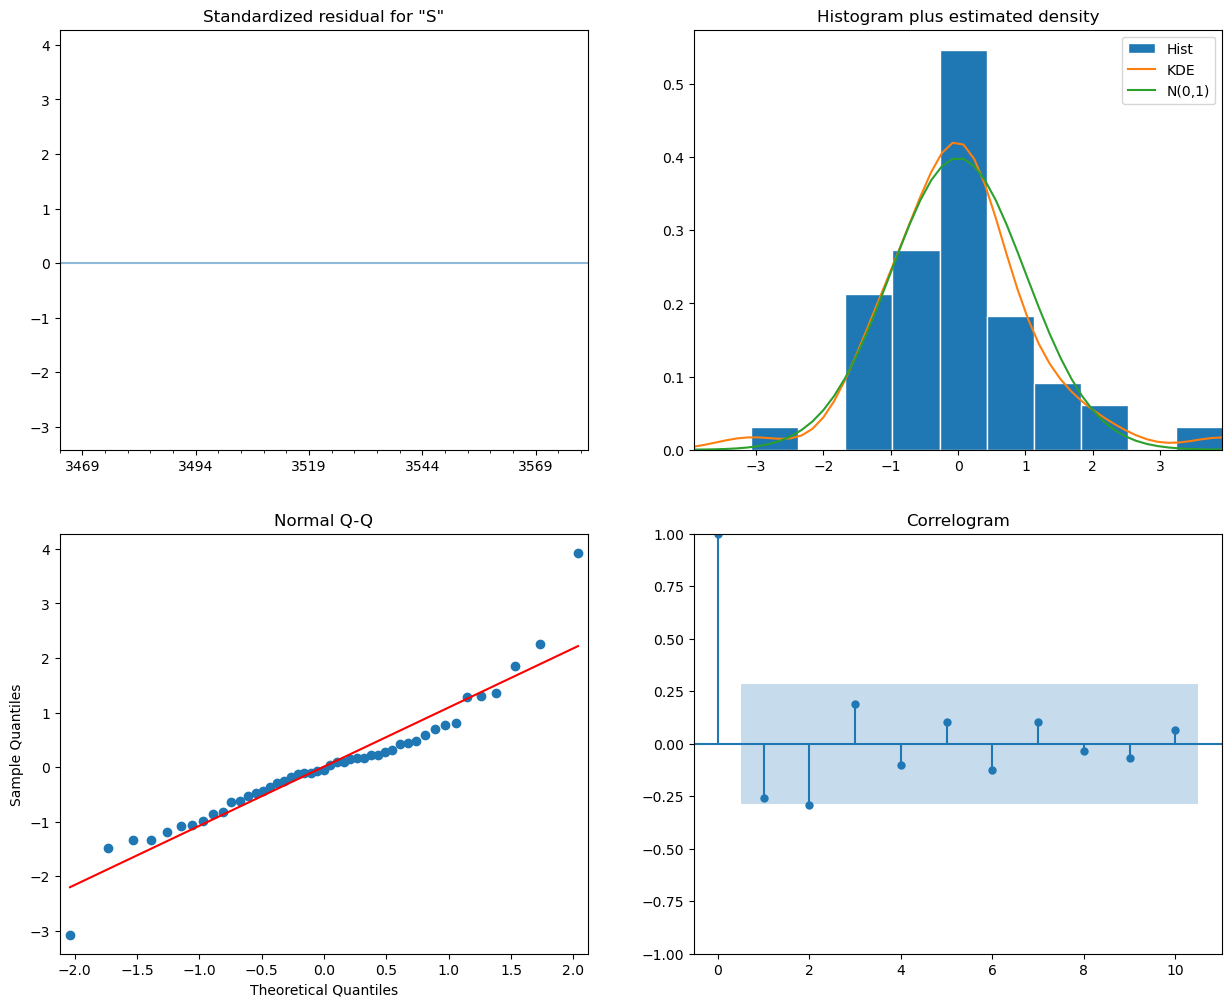

In [38]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [39]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [40]:
sales_d['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product D')

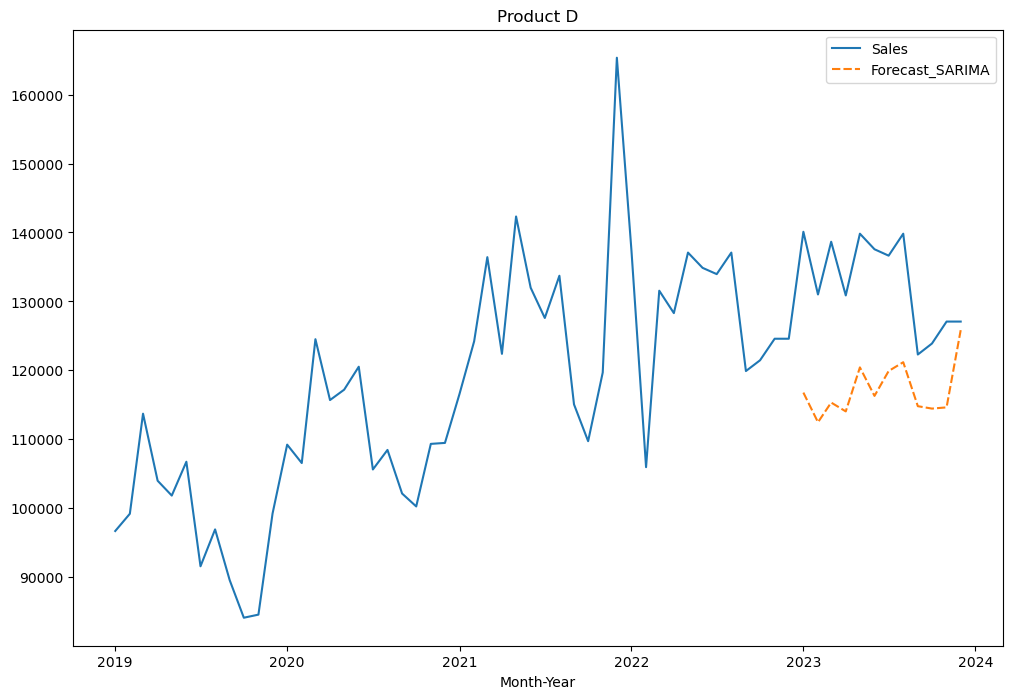

In [41]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_SARIMA']])
plt.title('Product D')

In [42]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 15727.508
MAPE - SARIMA: 0.117
MSE - SARIMA: 289548547.324
RMSE - SARIMA: 17016.126


# AUTO-ARIMA

In [43]:
import pmdarima as pm

In [44]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=3 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1029.162, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1029.090, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1027.011, Time=0.25 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1027.058, Time=0.41 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1028.486, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1030.154, Time=0.17 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1027.163, Time=0.31 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1029.057, Time=0.78 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1029.052, Time=0.25 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1028.040, Time=0.31 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1029.119, Time=0.45 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1031.051, Time=1.39 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=1026.901, Time=0.54 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=1028.895, Time=0.49 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=1030.882, Time=1.26

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(3, 0, 0, 12),
      suppress_warnings=True)

In [45]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(3, 0, [], 12)   Log Likelihood                -506.901
Date:                             Thu, 09 May 2024   AIC                           1025.802
Time:                                     16:33:42   BIC                           1036.902
Sample:                                 01-01-2019   HQIC                          1029.979
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    668.4297   2260.125      0.296      0.767   -3761.334    5098.193
ma.L1         -0.1955      0.098     -1.999      0.046      -0.387      -0.004
ar.S.L12       0.2002      0.206      0.972      0.331      -0.203       0.604
ar.S.L24       0.2098      0.164      1.282      0.200      -0.111       0.530
ar.S.L36      -0.3044      0.153     -1.984      0.047      -0.605      -0.004
sigma2      1.648e+08      0.006   2.98e+10      0.000    1.65e+08    1.65e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                11.69
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             0.51
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  7e+26. Standard errors may be unstable.
"""

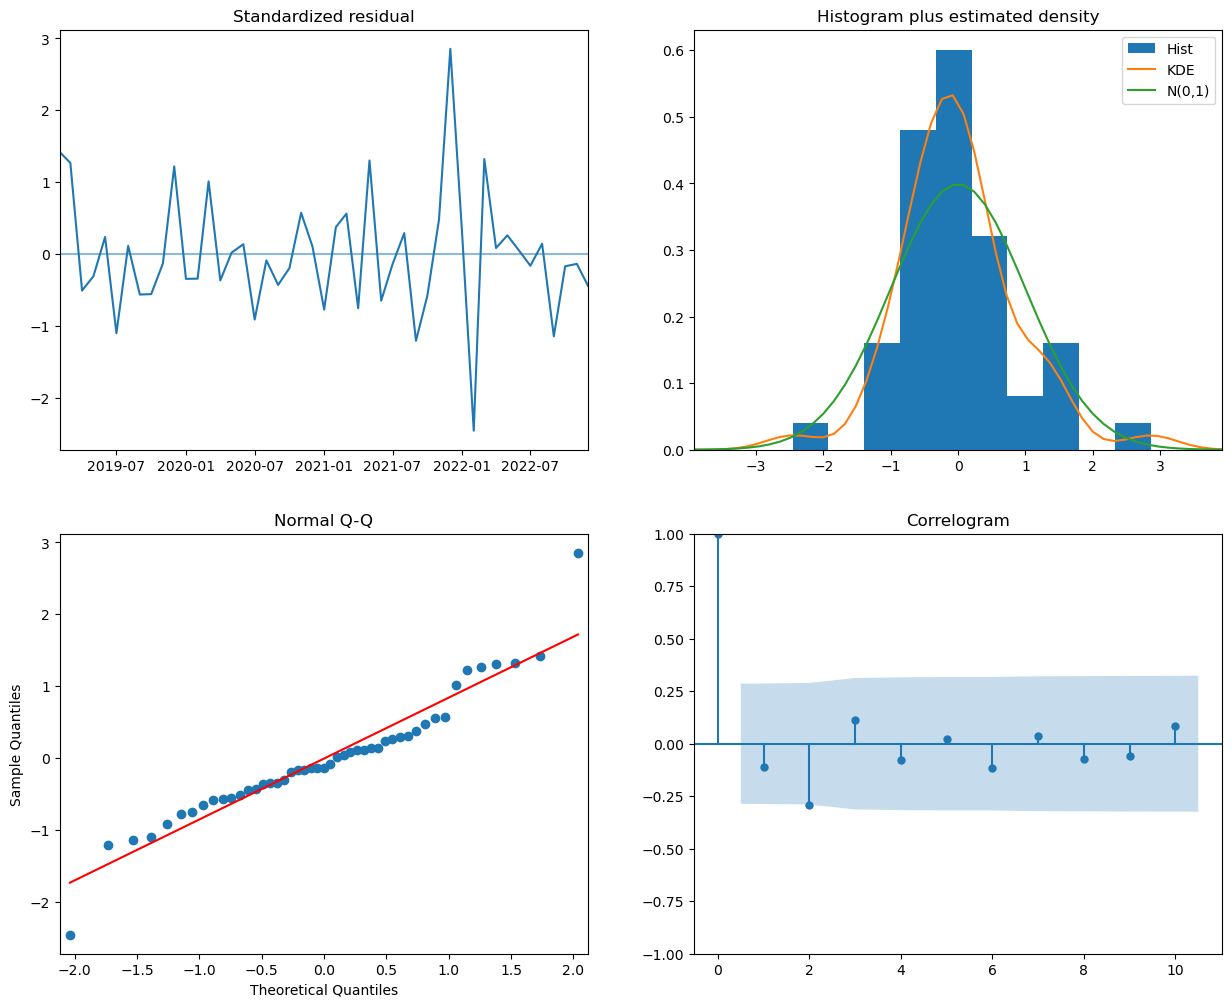

In [46]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [47]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_d[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product D')

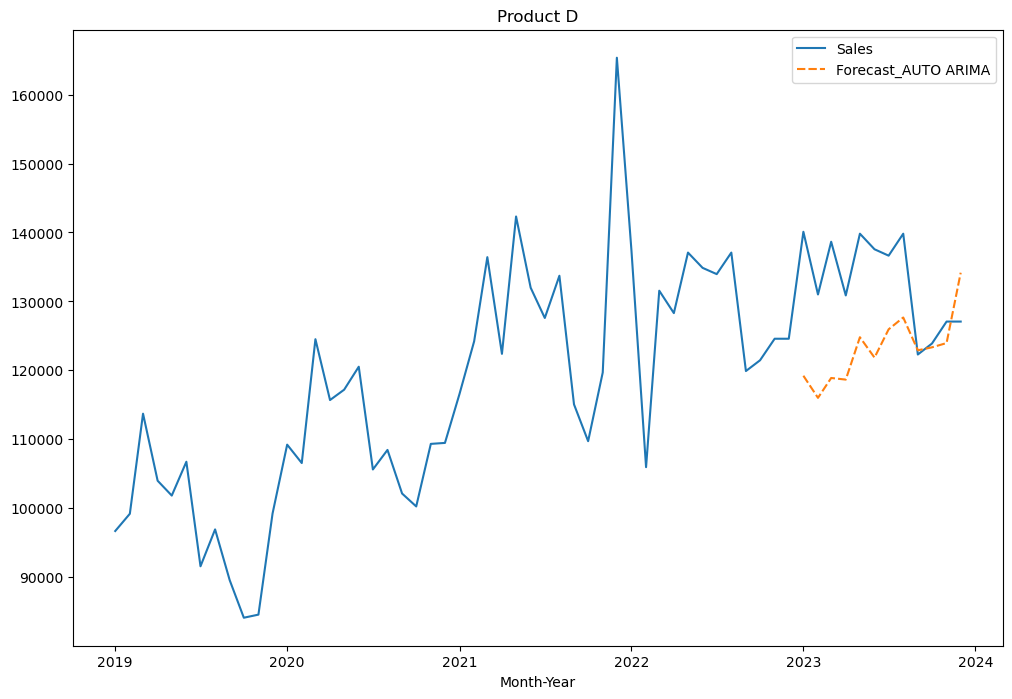

In [48]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product D')

In [49]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 11068.677390717747
MAPE - AUTO ARIMA: 0.08134296105127006
MSE - AUTO ARIMA: 166391629.23961398
RMSE - AUTO ARIMA: 12899.287935371238


In [50]:
sales_d.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,140104,124583.0,116768.030660,119214.660769
2023-02-01,131006,124583.0,112466.570217,116006.509844
2023-03-01,138656,124583.0,115324.418870,118889.083313
2023-04-01,130866,124583.0,114037.714778,118652.784781
2023-05-01,139824,124583.0,120425.861353,124802.345922
2023-06-01,137565,124583.0,116288.925337,121844.907714
2023-07-01,136637,124583.0,119897.336349,125949.711714
2023-08-01,139824,124583.0,121177.351412,127665.365393
2023-09-01,122293,124583.0,114795.918405,122903.705578


In [51]:
sales_d.mean()

Sales                  119558.133333
Forecast_ARIMA         124583.000000
Forecast_SARIMA        117173.325405
Forecast_AUTO ARIMA    123115.256658
dtype: float64

In [52]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,8815.500000,0.064455,1.096857e+08,10473.091982
AUTO ARIMA,11068.677391,0.081343,1.663916e+08,12899.287935
SEASONAL ARIMA,15727.507928,0.116625,2.895485e+08,17016.126096


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1029.162, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1029.090, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1027.011, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1028.486, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1030.154, Time=0.17 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1027.163, Time=0.44 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1029.052, Time=0.24 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1028.040, Time=0.31 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1029.119, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1029.921, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1029.928, Time=0.09 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1027.199, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1029.327, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1031.017, Time=0.20 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1026.346, Time=0.42

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -506.086
Date:                                 Wed, 08 May 2024   AIC                           1026.172
Time:                                         18:54:21   BIC                           1039.123
Sample:                                     01-01-2019   HQIC                          1031.045
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    764.6682    921.923      0.829      0.407   -1042.267    2571.604
ar.L1          0.6368      0.188      3.394      0.001       0.269       1.005
ma.L1         -0.9100      0.174     -5.227      0.000      -1.251      -0.569
ar.S.L12      -0.7092      0.898     -0.790      0.430      -2.469       1.051
ma.S.L12       0.9595      1.030      0.932      0.352      -1.059       2.978
ma.S.L24       0.4193      0.248      1.692      0.091      -0.066       0.905
sigma2      1.626e+08      0.002   6.62e+10      0.000    1.63e+08    1.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.50   Prob(JB):                         0.18
Heteroskedasticity (H):               1.60   Skew:                             0.19
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+27. Standard errors may be unstable.
"""

In [21]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product D')

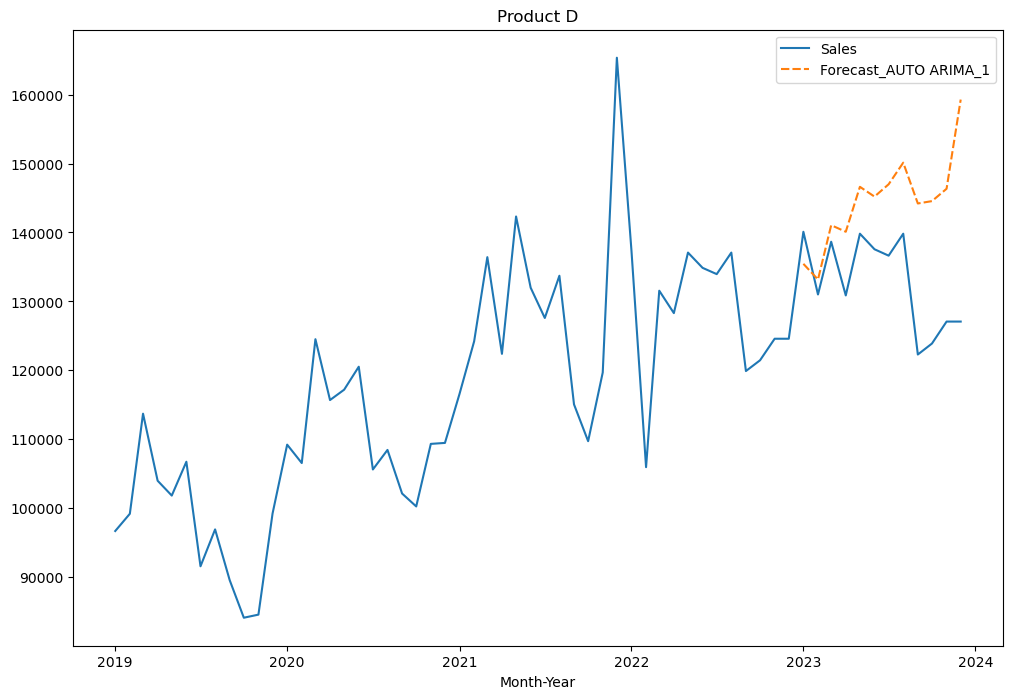

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product D')

In [23]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 12301.926198990162
MAPE - AUTO ARIMA: 0.09520571373070087
MSE - AUTO ARIMA: 229302604.24636534
RMSE - AUTO ARIMA: 15142.740975344104
